In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imutils
import easyocr
import datetime
import re

%matplotlib inline

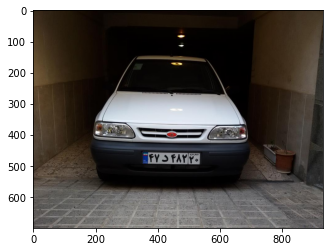

In [210]:
carplate_img = cv2.imread("test1/expo3358299/TamamrokhJolo.jpg")
carplate_img = cv2.cvtColor(carplate_img, cv2.COLOR_BGR2RGB)
plt.imshow(carplate_img)

In [211]:
start = datetime.datetime.now()
reader = easyocr.Reader(['fa']) # need to run only once to load model into memory
result = reader.readtext(carplate_img, detail = 1)
end = datetime.datetime.now()

print(end - start)

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


0:00:21.447010


In [212]:
result

[[[[367, 457], [537, 457], [537, 497], [367, 497]],
  '٤٨٢٢٠ ٥ ٤٧',
  0.7665368857658156]]

٤٨٢٢٠ ٥ ٤٧


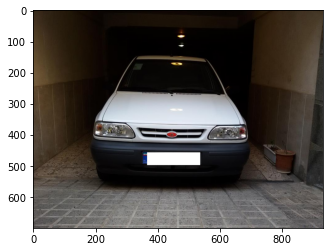

In [213]:
res = False
pattern = '\d*[\u0600-\u06FF]\d*'
prog = re.compile(pattern)

carplate_img_rgb = carplate_img.copy()
pnt = []
for i, r in enumerate(result):
    if prog.match(r[1]) and r[2]> 0.02:
        print(r[1])
        pnt = np.array(r[0], np.int)
        pnt = pnt.reshape((-1, 1, 2))
        isClosed = True
        color = list([255,255,255])
        thickness = 2

        carplate_img_rgb = cv2.fillPoly(carplate_img_rgb, [pnt], color) 
                              #isClosed, color, thickness)
        plt.imshow(carplate_img_rgb)
        

In [214]:
pnt = []
for i, r in enumerate(result):
    if prog.match(r[1]) and r[2]>0.02:
        pnt.append(r[0])

pnt = np.array(pnt, dtype=int)    
pnt = pnt.reshape(-1,2)
pnt0, pnt1, pnt2, pnt3 = [p for p in(pnt[:4])]
pnt

array([[367, 457],
       [537, 457],
       [537, 497],
       [367, 497]])

In [215]:
import math

teta = (np.arcsin(abs(pnt0[0] - pnt1[0])/np.linalg.norm(pnt0 - pnt1))/math.pi)*180
teta_rad = np.arcsin(abs(pnt0[0] - pnt1[0])/np.linalg.norm(pnt0 - pnt1))
teta

90.0

In [216]:
math.cos(teta_rad)

6.123233995736766e-17

In [217]:
dists = []
for i, p in enumerate(pnt):
    if i>0:
        dists.append(int(np.linalg.norm(np.array(pnt[i-1, :]) - np.array(pnt[i, :]))))
    else:
        dists.append(int(np.linalg.norm(np.array(pnt[0,:]) - np.array(pnt[-1,:]))))
    
dists = sorted(dists, reverse = True)
dim = (dists[0], dists[2])
w, h = dim
print(dim)

(170, 40)


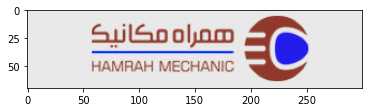

In [218]:
logo = cv2.imread("ham.jpg")
plt.imshow(logo)

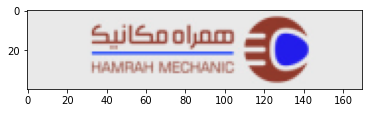

In [219]:
resized = cv2.resize(logo, dim, interpolation = cv2.INTER_AREA)
plt.imshow(resized)

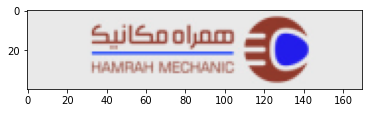

In [220]:
from scipy import ndimage

rotated = ndimage.rotate(resized, teta-90 ,cval=255)

# convert to graky
gray = cv2.cvtColor(rotated, cv2.COLOR_BGR2GRAY)

# threshold input image as mask
mask = cv2.threshold(gray, 250, 255, cv2.THRESH_BINARY)[1]

# negate mask
mask = 255 - mask

# apply morphology to remove isolated extraneous noise
# use borderconstant of black since foreground touches the edges
kernel = np.ones((3,3), np.uint8)
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

# anti-alias the mask -- blur then stretch
# blur alpha channel
mask = cv2.GaussianBlur(mask, (0,0), sigmaX=2, sigmaY=2, borderType = cv2.BORDER_DEFAULT)

# linear stretch so that 127.5 goes to 0, but 255 stays 255
mask = (2*(mask.astype(np.float32))-255.0).clip(0,255).astype(np.uint8)

# put mask into alpha channel
logo = rotated.copy()
logo = cv2.cvtColor(logo, cv2.COLOR_BGR2BGRA)
logo[:, :, 3] = mask

plt.imshow(logo)

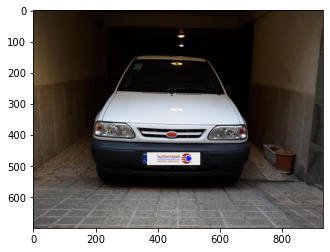

In [221]:
w,h,c = rotated.shape
out = carplate_img_rgb.copy()
if math.sin(teta_rad)==1.0:
    alpha= 0
else:
    alpha=0.6
beta = (1.0 - alpha)
out[pnt0[1]:pnt0[1]+w, pnt0[0]:pnt0[0]+h] = cv2.addWeighted(out[pnt0[1]:pnt0[1]+w, pnt0[0]:pnt0[0]+h],alpha,rotated,beta,1)
# out[pnt0[1]:pnt0[1]+w, pnt0[0]:pnt0[0]+h] = rotated
plt.imshow(out)

In [222]:
def overlay_transparent(bg_img, img_to_overlay_t):
    # Extract the alpha mask of the RGBA image, convert to RGB 
    bg_img_part = bg_img[pnt0[1]:pnt0[1]+w, pnt0[0]:pnt0[0]+h]
    
    b,g,r,a = cv2.split(img_to_overlay_t)
    overlay_color = cv2.merge((b,g,r))

    mask = cv2.medianBlur(a,5)

    # Black-out the area behind the logo in our original ROI
    img1_bg = cv2.bitwise_and(bg_img_part.copy(),bg_img_part.copy(),mask = cv2.bitwise_not(mask))

    # Mask out the logo from the logo image.
    img2_fg = cv2.bitwise_and(overlay_color,overlay_color,mask = mask)

    # Update the original image with our new ROI
    bg_img_part = cv2.add(img1_bg, img2_fg)
    
    bg_img[pnt0[1]:pnt0[1]+w, pnt0[0]:pnt0[0]+h] = bg_img_part
    
    return bg_img


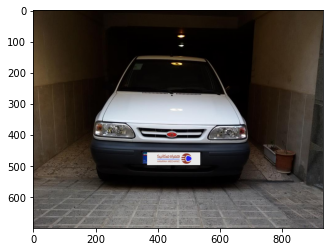

In [223]:
w,h,c = rotated.shape
out_over = carplate_img_rgb.copy()

plt.imshow(overlay_transparent(out_over, logo))

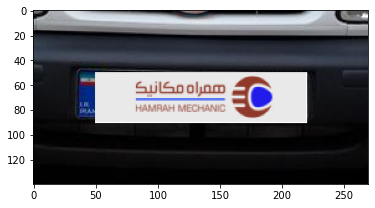

In [224]:
plt.imshow(out_over[pnt0[1]-50:pnt0[1]+w+50, pnt0[0]-50:pnt0[0]+h+50])